# Import Necessary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install emoji # https://pypi.org/project/emoji/
!pip install zeugma  # https://zeugma.readthedocs.io/
!pip install regex # https://docs.python.org/3/library/re.html
!pip install nltk  # https://www.nltk.org/
!pip install matplotlib.pyplot # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
!pip intall keras  # https://keras.io/
!pip install sklearn # https://scikit-learn.org/

import pandas as pd
import numpy as np
import regex as re
import string
import keras
import nltk
import emoji
import gc
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB,  MultinomialNB
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.utils import compute_class_weight
from sklearn.ensemble import RandomForestClassifier


from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, Embedding, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras import backend as K

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english')) - {'all'}

  Using cached https://files.pythonhosted.org/packages/24/fa/b3368f41b95a286f8d300e323449ab4e86b85334c2e0b477e94422b8ed0f/emoji-1.2.0-py3-none-any.whl
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
ERROR: unknown command "intall" - maybe you meant "install"
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Preprocessing

In [ ]:
# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocesses the tweets text
# This function is based on code from:
#   https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python

# Preprocessing takes in a tweet and a boolean determining if the preprocessing
# is for the GloVe embeddings or for other classifiers
# default value is: False

def preprocess_text(tweet, glove):
    # Changes emojis to words
    tweet = emoji.demojize(tweet,  delimiters=(' ', ' '))
    # Removes 'RT' from tweet
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Removes capitalization
    tweet = tweet.lower()
    # Removes single characters
    if glove: tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    # Removes all hashtags
    if glove: tweet = re.sub(r'#[a-zA-Z0-9]+\s+', ' ', tweet)
    # Removes all special characters
    if glove: tweet = re.sub(r'\W', ' ', tweet)
    #Removes Punctuation
    tweet = re.sub(r'\p{P}+', '', tweet)
    #Removes multiple spaces with single space
    if glove: tweet = re.sub(r'\s+', ' ', tweet, flags=re.MULTILINE)
    #Remove "blacklivesmatter"
    if glove: tweet = re.sub(r'blacklivesmatter', '', tweet)
    # Removes all special characters
    if glove: tweet = re.sub(r'\W', ' ', tweet)
    #Removes Punctuation
    tweet = re.sub(r'\p{P}+', '', tweet)
    #Removes multiple spaces with single space
    if glove: tweet = re.sub(r'\s+', ' ', tweet, flags=re.MULTILINE)
    # Removes stopwords
    tokens = [w for w in word_tokenize(tweet) if not w in stop_words]
    # Perfoms lemmatization on tokens
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemma_words)

# Preprocesses the text of the Tweets in the df and returns the df
# By default, this removes the Tweets with the "neither" label
def preprocess_df(df, glove, remove_neither=True):
  idx = "text"
  length = len(df[idx])
  for ii in range(length):
    tweet = str(df[idx][ii])
    df.loc[ii, idx] = preprocess_text(tweet, glove)
  if (remove_neither):
    return df[df['BLM'] != "neither"]
  else:
    return df

In [ ]:

# Retrieves and preprocesses the training dataset

# path = files.upload() # if using Google Colab directly
path = r"/content/drive/Shareddrives/COS424/combined_train.csv" # Path to Train_dataset.csv
train_df = pd.read_csv(path)
train_df.fillna("", inplace=True) # fills any NaN values with empty strings
glove_boolean = False; # optimize preprocessing for GloVe (default: false)
train_df = preprocess_df(train_df, glove_boolean)

In [ ]:

# Uses a TfidfVectorizer to construct bag-of-words matrix
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, binary=True, stop_words=None) # default max_features (i.e. none) & 1 to 3-gram_rang
default = True # set to False for SVC-optimized vectorizer

if default: vectorizer = TfidfVectorizer() # for Naive Bayes
else: vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=12000) # for SVC

# train_vocab is an 2d array of the vocab from the training dataset 
train_vocab = vectorizer.fit_transform(train_df['text'])
# train_hash = vectorizer.fit_transform(train_df['hashtags'])

# train_vocab_df is a dataframe where the element ij is the number of times word j occurred in Tweet i
# train_vocab_df = pd.DataFrame(train_vocab, columns=vectorizer.get_feature_names())
train_labels = train_df['BLM']

# Retrieves and preprocesses the test dataset
# test = files.upload()
path = r"/content/drive/Shareddrives/COS424/combined_test.csv" # Path to Test_dataset.csv
test_df = pd.read_csv(path)
test_df.fillna("", inplace=True) # fills any NaN values with empty strings
test_df = preprocess_df(test_df, glove_boolean)

# Uses the vocab from the training dataset to vectorize the test dataset
test_vocab = vectorizer.transform(test_df['text'])
# test_hash = vectorizer.fit_transform(test_df['hashtags'])

test_labels = test_df['BLM']

# Recurrent Neural Network

Necessary Functions for GloVe Embedding

In [ ]:
# All of the functions in this section are based on https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2

In [ ]:
# Loadand split vector embedding by index
def load_embed(file):
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [ ]:
# build vocabulary using embeddings
def build_vocab(texts):
  vocab = {}
  for tweet in texts:
    sentences = tweet.split()
    for word in sentences:
      ## for word in texts:
      ## for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1

  return vocab

In [ ]:
 # get coefficients 
  def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')

In [ ]:
# evaluate vector model by assessing vocab and text coverage on training set
def check_coverage(vocab, embeddings_index):
    import operator 
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [ ]:
vocab = build_vocab(train_df['text'])
print(vocab)      # full vocabulary in training set

{'great': 56, 'oped': 1, 'amp': 460, 'well': 132, 'worth': 18, 'read': 49, 'god': 40, 'bless': 12, 'thin': 1, 'blue': 24, 'line': 21, 'redcircle': 1, 'whitecircle': 1, 'bluecircle': 1, 'backtheblue': 10, 'bluelivesmatter': 142, 'maga': 7, 'thank': 62, 'all': 979, 'police': 482, 'first': 44, 'responder': 3, 'foldedhands': 9, 'truly': 16, 'take': 183, 'servant': 1, 'h': 4, 'mlk': 34, 'would': 118, 'sad': 44, 'learn': 31, 'u': 372, 'dont': 389, 'support': 158, 'human': 52, 'right': 200, 'life': 1044, 'unborn': 5, 'black': 1111, 'girls+boys': 1, 'matter': 904, 'matterjohnlewis': 1, 'obama': 64, 'friend': 44, 'harvey': 2, 'weinstein': 1, 'urge': 6, 'clinton': 20, 'campaign': 33, 'silence': 36, 'sander': 50, 'blacklivesmatter': 5971, 'message': 30, 'buildthewall': 2, 'want': 139, 'look': 93, 'filthy': 2, 'cleaning': 3, 'ccot': 6, 'tcot': 54, 'veteran': 6, '2a': 2, 'nra': 6, 'freedom': 30, 'never': 71, 'voluntarily': 3, 'give': 71, 'oppressor': 4, 'must': 88, 'demand': 53, 'oppress': 8, 'rais

In [ ]:
# Remove words which occur a single time
vocabCopy = vocab.copy();
for word in vocabCopy:
    if vocab.get(word) == 1: vocab.pop(word)

# Print Coverge
oov_glove = check_coverage(vocab, embed_glove)
print(oov_glove)  # all vocab which is not covered in embeddings. Useful for model optimization

In [ ]:
len_voc = 95000
max_len = 3000

In [ ]:
def make_data(X):
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

In [ ]:
def make_embed_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [ ]:
X, word_index = make_data(train_df['text'])

## Word Embedding Models

In [ ]:
# Code in this section is based on https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

In [ ]:
# By default, GloVe Wiki Model is enabled, as it has the highest overall coverage

vector_model = r"/home/asursock/glove.6B.300d.txt"           #GloVe Wiki Model
# vector_model = r"/home/asursock/glove.twitter.27B.200d.txt #GloVe Twitter Model
# vector_model = r"/home/asursock/crawl-300d-2M.vec"         #FastText Crawl Model

#extract vector model's embeddings
print("Extracting Vector Model embedding...")
# embed_glove = load_embed(vector_model)

In [ ]:
embedding = make_embed_matrix(embed_glove, word_index, len_voc)
del word_index
gc.collect()

24690

In [ ]:
def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp    = Input(shape=(max_len,))
    x      = Embedding(len_voc, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x      = Bidirectional(GRU(128, return_sequences=True))(x)
    x      = Bidirectional(GRU(64, return_sequences=True))(x)
    avg_pl = GlobalAveragePooling1D()(x)
    max_pl = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pl, max_pl])
    dense  = Dense(64, activation="sigmoid")(concat)
    drop   = Dropout(0.1)(concat)
    output = Dense(1, activation="sigmoid")(concat)
    
    model  = Model(inputs=inp, outputs=output)
    model.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=['accuracy', f1])
    return model

In [ ]:
model = make_model(embedding)
model_treated = make_model(embedding_treated)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3000)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 3000, 300)    28500000    input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 3000, 256)    330240      embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 3000, 128)    123648      bidirectional_4[0][0]            
____________________________________________________________________________________________

## RNN Classifier #1 (good)

In [ ]:
# Code in this section is based on https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector(vector_model)

maxLen = 3000 # max length of single feature (never reached)
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [ ]:
# Split Dataset into training and test set (by default random cross-validation is enabled)

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, train_df['BLM'])))
X_train, X_test,Y_train, Y_test = train_test_split(train_df['text'], y, test_size=0.2, random_state = 45)

# Optional: commented out section: use given split
# X_train = train_df['text']
# Y_train = y
# X_test = test_df['text']
# Y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, test_df['BLM'])))

In [ ]:
# Alternative Model Creation (not used in evaluation)
def sentiment(X_indices):
  embeddings = embedding_layer(X_indices)
  X = LSTM(128, return_sequences=True)(embeddings)
  X = Dropout(0.6)(X)
  X = LSTM(128, return_sequences=True)(X)
  X = Dropout(0.6)(X)
  X = LSTM(128)(X)
  X = Dense(1, activation='sigmoid')(X)
  model = Model(inputs=X_indices, outputs=X)
  return model

In [ ]:
# To activate alternative model above, uncomment the next line (disabled by default, as not optimized)

# model = sentiment(X_train_indices) # uncomment if alternative LSTM model is preferred over bidirectional

In [ ]:
# Tokenize and pad both the training and testing set
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

#### Fit and run RNN Classifier #1
WARNING: computationally heavy. Only run with appropriate hardware!!

In [ ]:
# Fit and run full model 

adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

print("Fitted Model:")
model.fit(X_train_indices, Y_train, batch_size=128, epochs=15)

print("Training Set Accuracy:")
model.evaluate(X_test_indices, Y_test) # find accuracy and loss rate on test set

 6/46 [==>...........................] - ETA: 4:29 - loss: 0.3186 - accuracy: 0.8619

## Run Classifier \#2 (bad)

In [ ]:
# This following functions are based on https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2

In [ ]:
# For evaluation purposes (recall, precision, and F1 Score)

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
y = train_df['BLM']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=420)
X_t_train, X_t_val, _, _ = train_test_split(X_treated, y, test_size=0.1, random_state=420)
print(f"Training on {X_train.shape[0]} texts")

Training on 6514 texts


In [ ]:
checkpoints = ModelCheckpoint('weights.hdf5', monitor="accuracy", mode="max", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)
checkpoints_treated = ModelCheckpoint('treated_weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr_treated = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

In [ ]:
# Transform labels into floats for computation
y_train_float = []
for label in y_train:
  if label == 'negative': y_train_float.append(0.0)
  elif label == 'positive': y_train_float.append(1.0)
  else: print('error')


In [ ]:
y_val_float = []
for label in y_val:
  if label == 'negative': y_val_float.append(0.0)
  elif label == 'positive': y_val_float.append(1.0)
  else: print('error')


In [ ]:
y_train_float = np.array(y_train_float)

In [ ]:
y_val_float = np.array(y_val_float)

### Fit and run RNN Classifier \#2

In [ ]:
classWeight = compute_class_weight('balanced', y_train_float, [0.0, 1.0]) 
classWeight = dict(enumerate(classWeight))

/home/asursock/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[1. 1. 0. ... 0. 0. 0.], y=[0.0, 1.0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [ ]:
epochs = 1 # adjust number of epochs & batch-size for optimization
batch_size = 524
history = model.fit(X_train, y_train_float, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_val, y_val_float), callbacks=[checkpoints, reduce_lr], class_weight=classWeight)

66/66 [==============================] - 428s 6s/step - loss: 0.5475 - accuracy: 0.7223 - f1: 0.7762 - val_loss: 0.5048 - val_accuracy: 0.7873 - val_f1: 0.8876

Epoch 00001: val_f1 improved from -inf to 0.88765, saving model to weights.hdf5


In [ ]:
pred_val = model.predict(X_val, batch_size=512, verbose=1)

In [ ]:
def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

In [ ]:
score_val, threshold_val = tweak_threshold(pred_val, y_val_float)

print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with texts on validation data")

In [ ]:
score = history.score(x_test, test_labels)
print(score)

# Classifier Testing

## 1. Bernoulli Naive Bayes

In [ ]:
bnb = BernoulliNB()
bnb.fit(train_vocab, train_labels)
bnbScore = bnb.score(test_vocab, test_labels)

print(bnbScore)

0.823302043070127


## 2. Multinomial Naive Bayes

In [ ]:
multi = MultinomialNB()
multi.fit(train_vocab, train_labels)
multiScore = multi.score(test_vocab, test_labels)

print(multiScore)

0.816123688569851


## 3. KNeighbours

### Cross Validation

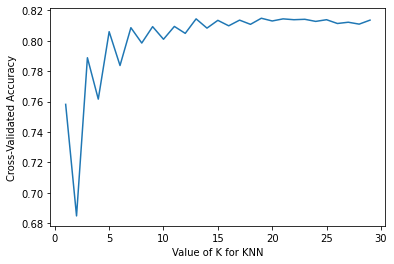

k = 18 gave the highest accuracy score of 0.8148613435424833


In [ ]:
# This function is adapted from a Princeton Data Science Workshop (https://colab.research.google.com/drive/1J-QVJyy8ExPU2oQR3C-6U0G74ocxtNkg?usp=sharing)
# Use cross validation to find optimal parameters

# Cross validation to find the best k 
# choose k between 1 to 30
k_range = range(1, 30)
k_scores = []
# use iteration to calculate different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_vocab, train_labels, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print("k = " + str(k_scores.index(max(k_scores))) + " gave the highest accuracy score of " + str(max(k_scores)))

### Grid Search

In [ ]:
# Grid Search for Parameter Tuning
parameters = {'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'), 'weights':('uniform', 'distance')}
knn = GridSearchCV(KNeighborsClassifier(), parameters)
knn.fit(train_vocab, train_labels)


knn.score(test_vocab, test_labels)
## results(knn, test_vocab, test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/usr/local/lib/python3.7/dist-packages/sklear

0.8227498619547211

### Run optimized version

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh = neigh.fit(train_vocab, train_labels)
neighScore = neigh.score(test_vocab, test_labels)
print(neighScore)

# results(model, test_vocab, test_labels) 


0.8244064053009387


## Logistic Regression

### Grid Search

In [ ]:
#GridSearch to hypertune parameters of logistic regression

parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
lr = GridSearchCV(LogisticRegression(), parameters)
lr.fit(train_vocab, train_labels)
estimator = lr.best_estimator_

print(estimator)
## results(knn, test_vocab, test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


### Run optimized version

In [ ]:
clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False).fit(train_vocab, train_labels)
clf.predict(test_vocab)
clfscore = clf.score(test_vocab, test_labels)
print(clfscore)

0.8354500276090557


## SVC

### Grid Search

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
svc = GridSearchCV(svc, parameters)
svc.fit(train_vocab, train_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Run optimized version

In [ ]:
svcScore = svc.score(test_vocab, test_labels)
print(svcScore)

0.8382109331860851


## Random Forest

### Run unoptimized verision

In [ ]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(train_vocab, train_labels)
rfcScore = rfc.score(test_vocab, test_labels)
print(rfcScore)

0.8139149641082275


### Grid Search

In [ ]:
parameters = {'criterion':('gini','entropy')}
sd = GridSearchCV(RandomForestClassifier(), parameters)
sd.fit(train_vocab, train_labels)
param = sd.best_params_
estimator = sd.best_estimator_
print(estimator)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


### Run optimized version

In [ ]:
tr = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
tr.fit(train_vocab, train_labels)
trScore = tr.score(test_vocab, test_labels)

# Ensemble Classifier Testing

In [ ]:
def predict(model, weight, val, ensemblePredictions, index):
    prediction = model.predict(val)
    if prediction == 'positive':
       ensemblePredictions[index] += 1*(weight*weight)
    else:
      ensemblePredictions[index] -= 2*(weight)

In [ ]:
ensemblePredictions = []
finalVerdict = []
index = 0
for val in test_vocab:
    ensemblePredictions.append(0)
    predict(clf, 0.8, val, ensemblePredictions, index)
    # predict(model, 0.5, val, ensemblePredictions, index)   # RNN model - not added
    predict(bnb, bnbScore, val, ensemblePredictions, index)
    # predict(multi, multiScore, val, ensemblePredictions, index)    # MultiNB removed for efficiency
    predict(neigh, neighScore, val, ensemblePredictions, index)
    predict(tr, trScore, val, ensemblePredictions, index)
    predict(svc, svcScore, val, ensemblePredictions, index)
    if ensemblePredictions[index] > 0:
      finalVerdict.append('positive')
    else:
       finalVerdict.append('negative')
    index += 1

from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, finalVerdict))
count = 0
for val in finalVerdict:
  if val == 'negative': count += 1

print(count)

AttributeError: ignored

# Evaluation

Code in this section is from: https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

In [ ]:
plt.figure(0).clf()
fpr, tpr, thresh = metrics.roc_curve(test_labels, tr.predict(test_vocab))
auc = metrics.roc_auc_score(test_labels, tr.predict(test_vocab))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_labels, neigh.predict(test_vocab))
auc = metrics.roc_auc_score(test_labels, neigh.predict(test_vocab))
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
metrics.plot_roc_curve(clf, test_vocab, test_labels)
metrics.plot_precision_recall_curve(clf, test_vocab, test_labels)
plt.show()  

In [ ]:
# change test_labels into numerical form
labelInFloat = []
for label in test_labels:
  if label == 'negative': labelInFloat.append(0.0)
  elif label == 'positive': labelInFloat.append(1.0)
  else: print('error')

In [ ]:
# calculate the roc curve and auc score for each classifier

classifiers = [rfc, clf, svc, neigh, multi, bnb]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
# Train the models and record the results
for cls in classifiers:
    model = cls.fit(train_vocab, train_labels)
    yproba = model.predict_proba(test_vocab)[::,1]
    
    fpr, tpr, _ = roc_curve(labelInFloat, yproba)
    auc = roc_auc_score(labelInFloat, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

In [ ]:
# code to add the ensemble classifer into results table
fpr, tpr, _ = roc_curve(labelInFloat, finalVerdict)
result_table = result_table.append({'classifiers':ens.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

In [ ]:
# plot all the curves on one figure
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()